In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np

In [2]:
df_train= pd.read_csv("../data/processed/train_w_desc.csv")
df_test= pd.read_csv("../data/processed/test_w_desc.csv")
df_valid= pd.read_csv("../data/processed/valid_w_desc.csv")
train_rdkfp= pd.read_csv("../data/processed/train_rdkfp.csv")
valid_rdkfp= pd.read_csv("../data/processed/valid_rdkfp.csv")
test_rdkfp= pd.read_csv("../data/processed/test_rdkfp.csv")


In [3]:
X_train= df_train[["tpsa","mol_w","qed","HBA","HBD","logP","MR"]]
y_train= df_train["Y"]
X_test= df_test[["tpsa","mol_w","qed","HBA","HBD","logP","MR"]]
y_test= df_test["Y"]
X_valid= df_valid[["tpsa","mol_w","qed","HBA","HBD","logP","MR"]]
y_valid= df_valid["Y"]

In [4]:
X_train= X_train.join(train_rdkfp)
X_test= X_test.join(test_rdkfp)
X_valid= X_valid.join(valid_rdkfp)

In [5]:
X_train.head()

,tpsa,mol_w,qed,HBA,HBD,logP,MR,Bit_0,Bit_1,Bit_2,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
0,45.20,319.096508,0.434358,0,0,2.6669,70.4260,0,0,0,...,0,0,0,0,1,0,1,1,1,0
1,20.31,291.071785,0.581359,2,0,4.9890,87.3330,0,1,0,...,1,0,1,1,0,0,0,1,1,1
2,47.56,263.047808,0.790087,3,1,3.9330,65.9332,0,1,1,...,1,1,1,0,0,1,0,1,1,0
3,57.53,138.031694,0.610259,3,2,1.0904,35.0661,0,0,1,...,0,1,0,0,0,1,0,0,1,0
4,172.56,397.962705,0.374691,10,0,4.1188,91.2156,0,0,0,...,0,0,0,1,0,1,1,1,1,0


In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
scaler= MinMaxScaler()

In [8]:
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled= scaler.fit_transform(X_test)
X_valid_scaled= scaler.fit_transform(X_valid)

In [9]:
X_train_scaled.shape, X_test_scaled.shape, X_valid_scaled.shape

((28789, 2055), (8225, 2055), (4113, 2055))

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
y_train.value_counts()

0    27800
1      989
Name: Y, dtype: int64

In [ ]:
(989/(27800+989))*100

3.435339886762305

In [ ]:
y_valid.value_counts()

0    3956
1     157
Name: Y, dtype: int64

In [69]:
157/(3956+157)

0.03817165086311695

In [119]:
model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(X_train_scaled.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 256)               526336    
                                                                 
 dense_53 (Dense)            (None, 256)               65792     
                                                                 
 dropout_26 (Dropout)        (None, 256)               0         
                                                                 
 dense_54 (Dense)            (None, 256)               65792     
                                                                 
 dropout_27 (Dropout)        (None, 256)               0         
                                                                 
 dense_55 (Dense)            (None, 1)                 257       
                                                                 
Total params: 658,177
Trainable params: 658,177
Non-t

In [15]:
#some of the metrics suggested by keras for imbalanced data
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(curve="ROC", name="roc-auc")
    ]

In [121]:
model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss="binary_crossentropy", metrics=metrics
)

In [122]:
#penalize 0 in favour of 1s. weight_i= 1/number of each value
weight_0 = 1/27800
weight_1= 1/989


In [123]:
class_weight= {0: weight_0, 1: weight_1}

In [113]:
callbacks = [keras.callbacks.ModelCheckpoint("hts_hiv{epoch}.h5")]

In [124]:
history= model.fit(
    X_train_scaled,
    y_train,
    batch_size=16,
    epochs=5,
    class_weight= class_weight,
    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1800/1800 [==============================] - 26s 14ms/step - loss: 5.8037e-05 - fn: 427.0000 - fp: 15478.0000 - tp: 562.0000 - recall: 0.5683 - roc-auc: 0.4936 - val_loss: 0.6572 - val_fn: 157.0000 - val_fp: 0.0000e+00 - val_tp: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.5000
Epoch 2/5
1800/1800 [==============================] - 27s 15ms/step - loss: 4.8281e-05 - fn: 601.0000 - fp: 12119.0000 - tp: 388.0000 - recall: 0.3923 - roc-auc: 0.4751 - val_loss: 0.6929 - val_fn: 157.0000 - val_fp: 9.0000 - val_tp: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.4999
Epoch 3/5
1800/1800 [==============================] - 27s 15ms/step - loss: 4.8265e-05 - fn: 523.0000 - fp: 13399.0000 - tp: 466.0000 - recall: 0.4712 - roc-auc: 0.4959 - val_loss: 0.6930 - val_fn: 157.0000 - val_fp: 0.0000e+00 - val_tp: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.5000
Epoch 4/5
1800/1800 [==============================] - 28s 15ms/step - loss: 4.8058e-05 - fn: 576.0000 - fp: 1127

In [77]:
history.history

{'loss': [2.358515739440918,
  1.383490800857544,
  1.3848257064819336,
  1.382908821105957,
  1.3824474811553955],
 'tp': [802.0, 840.0, 900.0, 796.0, 827.0],
 'recall': [0.8109201192855835,
  0.8493427634239197,
  0.9100100994110107,
  0.8048533797264099,
  0.8361981511116028],
 'val_loss': [0.7105528712272644,
  0.7230435013771057,
  0.7172530889511108,
  0.7128604054450989,
  0.7358821630477905],
 'val_tp': [157.0, 157.0, 157.0, 157.0, 157.0],
 'val_recall': [1.0, 1.0, 1.0, 1.0, 1.0]}

In [125]:
preds= model.predict(X_test_scaled)

258/258 [==============================] - 1s 3ms/step


In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [126]:
cmat= confusion_matrix(y_test, (preds>= 0.5))

In [127]:
cmat

array([[   0, 7928],
       [   0,  297]], dtype=int64)

In [128]:
history2= model.fit(
    X_train_scaled,
    y_train,
    batch_size=16,
    epochs=5,
    class_weight= class_weight,
    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1800/1800 [==============================] - 27s 15ms/step - loss: 4.8090e-05 - fn: 503.0000 - fp: 14479.0000 - tp: 486.0000 - recall: 0.4914 - roc-auc: 0.4798 - val_loss: 0.6927 - val_fn: 157.0000 - val_fp: 0.0000e+00 - val_tp: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.5000
Epoch 2/5
1800/1800 [==============================] - 29s 16ms/step - loss: 4.8047e-05 - fn: 583.0000 - fp: 10766.0000 - tp: 406.0000 - recall: 0.4105 - roc-auc: 0.5070 - val_loss: 0.6553 - val_fn: 157.0000 - val_fp: 0.0000e+00 - val_tp: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.5000
Epoch 3/5
1800/1800 [==============================] - 26s 15ms/step - loss: 4.8063e-05 - fn: 550.0000 - fp: 12241.0000 - tp: 439.0000 - recall: 0.4439 - roc-auc: 0.5052 - val_loss: 0.7015 - val_fn: 0.0000e+00 - val_fp: 3956.0000 - val_tp: 157.0000 - val_recall: 1.0000 - val_roc-auc: 0.5000
Epoch 4/5
1800/1800 [==============================] - 26s 14ms/step - loss: 4.8091e-05 - fn: 496.0000 - fp: 13853

In [129]:
class_weight= {0: 0.1, 1: 0.5}

In [130]:
history3= model.fit(
    X_train_scaled,
    y_train,
    batch_size=256,
    epochs=50,
    class_weight= class_weight,
    validation_data=(X_valid_scaled, y_valid))

Epoch 1/50
113/113 [==============================] - 3s 26ms/step - loss: 0.0509 - fn: 963.0000 - fp: 492.0000 - tp: 26.0000 - recall: 0.0263 - roc-auc: 0.5297 - val_loss: 0.2190 - val_fn: 157.0000 - val_fp: 0.0000e+00 - val_tp: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.4999
Epoch 2/50
113/113 [==============================] - 3s 26ms/step - loss: 0.0481 - fn: 983.0000 - fp: 0.0000e+00 - tp: 6.0000 - recall: 0.0061 - roc-auc: 0.4937 - val_loss: 0.2230 - val_fn: 157.0000 - val_fp: 0.0000e+00 - val_tp: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.4999
Epoch 3/50
113/113 [==============================] - 3s 26ms/step - loss: 0.0481 - fn: 983.0000 - fp: 0.0000e+00 - tp: 6.0000 - recall: 0.0061 - roc-auc: 0.4877 - val_loss: 0.2245 - val_fn: 157.0000 - val_fp: 0.0000e+00 - val_tp: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.4999
Epoch 4/50
113/113 [==============================] - 3s 24ms/step - loss: 0.0481 - fn: 983.0000 - fp: 0.0000e+00 - tp: 6.0000 - recal

In [132]:
model2 = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(X_train_scaled.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 256)               526336    
                                                                 
 dense_57 (Dense)            (None, 256)               65792     
                                                                 
 dropout_28 (Dropout)        (None, 256)               0         
                                                                 
 dense_58 (Dense)            (None, 512)               131584    
                                                                 
 dropout_29 (Dropout)        (None, 512)               0         
                                                                 
 dense_59 (Dense)            (None, 256)               131328    
                                                                 
 dropout_30 (Dropout)        (None, 256)             

In [133]:
model2.compile(
    optimizer=keras.optimizers.Adam(0.001), loss="binary_crossentropy", metrics=metrics
)

In [134]:
history= model2.fit(
    X_train_scaled,
    y_train,
    batch_size=16,
    epochs=50,
    class_weight= class_weight,
    validation_data=(X_valid_scaled, y_valid))

Epoch 1/50
1800/1800 [==============================] - 35s 18ms/step - loss: 0.0541 - fn: 1145.0000 - fp: 65.0000 - tp: 1.0000 - recall: 8.7260e-04 - roc-auc: 0.5195 - val_loss: 0.2456 - val_fn: 157.0000 - val_fp: 0.0000e+00 - val_tp: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.5273
Epoch 2/50
1800/1800 [==============================] - 33s 18ms/step - loss: 0.0490 - fn: 989.0000 - fp: 1.0000 - tp: 0.0000e+00 - recall: 0.0000e+00 - roc-auc: 0.5873 - val_loss: 0.2728 - val_fn: 157.0000 - val_fp: 0.0000e+00 - val_tp: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.6120
Epoch 3/50
1800/1800 [==============================] - 32s 18ms/step - loss: 0.0458 - fn: 981.0000 - fp: 23.0000 - tp: 8.0000 - recall: 0.0081 - roc-auc: 0.6851 - val_loss: 0.2090 - val_fn: 157.0000 - val_fp: 0.0000e+00 - val_tp: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.5984
Epoch 4/50
1800/1800 [==============================] - 33s 18ms/step - loss: 0.0446 - fn: 942.0000 - fp: 215.0000 - tp: 

In [136]:
history.history

{'loss': [0.054069384932518005,
  0.04896288365125656,
  0.045837607234716415,
  0.04463626444339752,
  0.04082927480340004,
  0.03979445993900299,
  0.049013737589120865,
  0.04786992073059082,
  0.0489296019077301,
  0.04750298708677292,
  0.049704864621162415,
  0.05031265690922737,
  0.04856368526816368,
  0.05047784000635147,
  0.04891759529709816,
  0.04816596582531929,
  0.048713091760873795,
  0.051177483052015305,
  0.04914771020412445,
  0.04939641058444977,
  0.05025376006960869,
  0.04924857243895531,
  0.051515329629182816,
  0.05086948350071907,
  0.05070803314447403,
  0.0492943599820137,
  0.050460971891880035,
  0.04948095977306366,
  0.05000612512230873,
  0.05326201021671295,
  0.048233430832624435,
  0.05065695941448212,
  0.05109412223100662,
  0.048711393028497696,
  0.049603287130594254,
  0.05040346086025238,
  0.048876941204071045,
  0.05432295799255371,
  0.05028167739510536,
  0.05213584378361702,
  0.049288857728242874,
  0.0506722591817379,
  0.050511151552

In [137]:
pd.DataFrame(history.history)

,loss,fn,fp,tp,recall,roc-auc,val_loss,val_fn,val_fp,val_tp,val_recall,val_roc-auc
0,0.054069,1145.0,65.0,1.0,0.000873,0.519510,0.245625,157.0,0.0,0.0,0.000000,0.527311
1,0.048963,989.0,1.0,0.0,0.000000,0.587315,0.272830,157.0,0.0,0.0,0.000000,0.612032
2,0.045838,981.0,23.0,8.0,0.008089,0.685096,0.209031,157.0,0.0,0.0,0.000000,0.598383
3,0.044636,942.0,215.0,47.0,0.047523,0.730915,0.153123,157.0,0.0,0.0,0.000000,0.788807
4,0.040829,757.0,586.0,232.0,0.234580,0.773778,0.342855,157.0,0.0,0.0,0.000000,0.694696
5,0.039794,711.0,617.0,278.0,0.281092,0.784191,0.223130,81.0,138.0,76.0,0.484076,0.797651
6,0.049014,883.0,240.0,106.0,0.107179,0.602063,0.267071,157.0,0.0,0.0,0.000000,0.508438
7,0.047870,979.0,8.0,10.0,0.010111,0.623896,0.336467,157.0,2.0,0.0,0.000000,0.530168
8,0.048930,976.0,1.0,13.0,0.013145,0.538807,0.220421,157.0,2.0,0.0,0.000000,0.536942
9,0.047503,978.0,5.0,11.0,0.011122,0.607978,0.245849,157.0,2.0,0.0,0.000000,0.502275


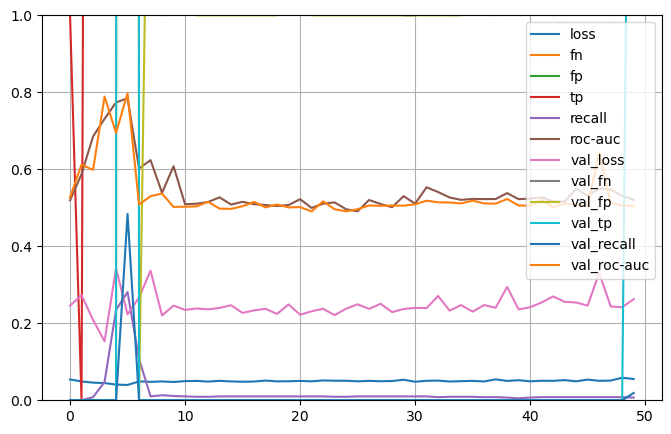

In [138]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [141]:
model3 = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(X_train_scaled.shape[-1],)
        ),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 256)               526336    
                                                                 
 dense_73 (Dense)            (None, 512)               131584    
                                                                 
 dropout_38 (Dropout)        (None, 512)               0         
                                                                 
 dense_74 (Dense)            (None, 512)               262656    
                                                                 
 dropout_39 (Dropout)        (None, 512)               0         
                                                                 
 dense_75 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_40 (Dropout)        (None, 1024)            

In [142]:
model3.compile(
    optimizer=keras.optimizers.Adam(0.001), loss="binary_crossentropy", metrics=metrics
)

In [144]:
class_weight= {0: 0.1, 1: 1.5}

In [145]:
history= model3.fit(
    X_train_scaled,
    y_train,
    batch_size=16,
    epochs=50,
    class_weight= class_weight,
    validation_data=(X_valid_scaled, y_valid))

Epoch 1/50
1800/1800 [==============================] - 80s 43ms/step - loss: 0.1104 - fn: 1095.0000 - fp: 1252.0000 - tp: 51.0000 - recall: 0.0445 - roc-auc: 0.4951 - val_loss: 0.4079 - val_fn: 157.0000 - val_fp: 0.0000e+00 - val_tp: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.5013
Epoch 2/50
1800/1800 [==============================] - 76s 42ms/step - loss: 0.0960 - fn: 978.0000 - fp: 74.0000 - tp: 11.0000 - recall: 0.0111 - roc-auc: 0.5041 - val_loss: 0.5226 - val_fn: 157.0000 - val_fp: 1.0000 - val_tp: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.4995
Epoch 3/50
1800/1800 [==============================] - 77s 43ms/step - loss: 0.0980 - fn: 973.0000 - fp: 37.0000 - tp: 16.0000 - recall: 0.0162 - roc-auc: 0.5152 - val_loss: 0.3460 - val_fn: 157.0000 - val_fp: 1.0000 - val_tp: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.5017
Epoch 4/50
1800/1800 [==============================] - 75s 42ms/step - loss: 0.0976 - fn: 976.0000 - fp: 31.0000 - tp: 13.0000 - recal

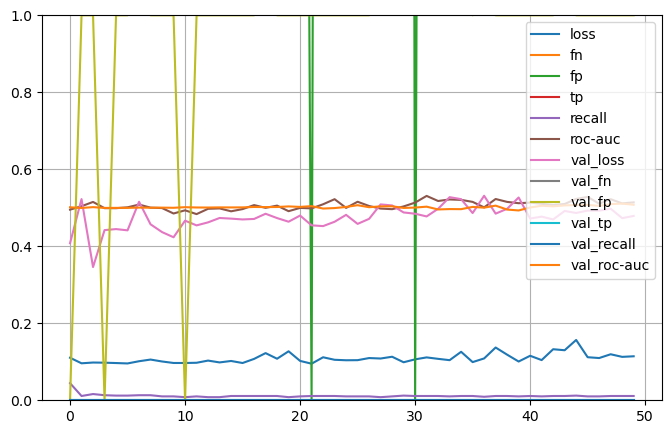

In [146]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [147]:
model4 = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(X_train_scaled.shape[-1],)
        ),
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model4.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 256)               526336    
                                                                 
 dense_79 (Dense)            (None, 1024)              263168    
                                                                 
 dropout_42 (Dropout)        (None, 1024)              0         
                                                                 
 dense_80 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 790,529
Trainable params: 790,529
Non-trainable params: 0
_________________________________________________________________


In [148]:
model4.compile(
    optimizer=keras.optimizers.SGD(), loss="binary_crossentropy", metrics=metrics
)

In [18]:
class_weight= {0: 0.1, 1: 1.8}

In [150]:
history= model4.fit(
    X_train_scaled,
    y_train,
    batch_size=16,
    epochs=50,
    class_weight= class_weight,
    validation_data=(X_valid_scaled, y_valid))

Epoch 1/50
1800/1800 [==============================] - 17s 9ms/step - loss: 0.1013 - fn: 817.0000 - fp: 4351.0000 - tp: 329.0000 - recall: 0.2871 - roc-auc: 0.6237 - val_loss: 1.5635 - val_fn: 6.0000 - val_fp: 3590.0000 - val_tp: 151.0000 - val_recall: 0.9618 - val_roc-auc: 0.6957
Epoch 2/50
1800/1800 [==============================] - 13s 7ms/step - loss: 0.0890 - fn: 479.0000 - fp: 3996.0000 - tp: 510.0000 - recall: 0.5157 - roc-auc: 0.7539 - val_loss: 1.1466 - val_fn: 19.0000 - val_fp: 2979.0000 - val_tp: 138.0000 - val_recall: 0.8790 - val_roc-auc: 0.7435
Epoch 3/50
1800/1800 [==============================] - 13s 7ms/step - loss: 0.0827 - fn: 441.0000 - fp: 3609.0000 - tp: 548.0000 - recall: 0.5541 - roc-auc: 0.7927 - val_loss: 0.4180 - val_fn: 69.0000 - val_fp: 512.0000 - val_tp: 88.0000 - val_recall: 0.5605 - val_roc-auc: 0.7714
Epoch 4/50
1800/1800 [==============================] - 13s 7ms/step - loss: 0.0771 - fn: 406.0000 - fp: 3421.0000 - tp: 583.0000 - recall: 0.5895 - ro

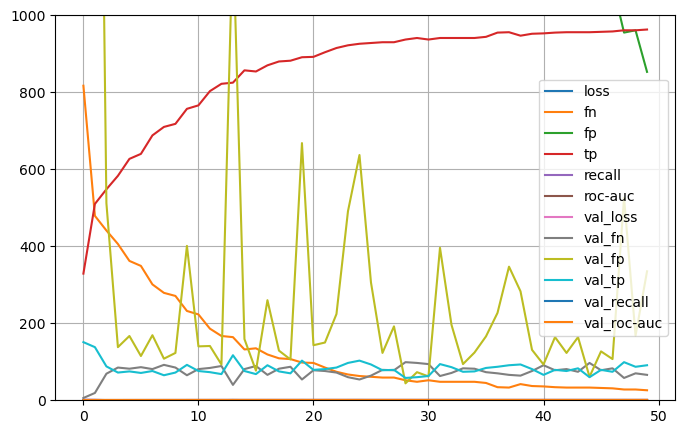

In [153]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1000)
plt.show()

In [154]:
import pickle

In [155]:
with open("../model/simple_deep_l_model.pkl", "wb") as save_file:
    pickle.dump(model4, save_file)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dropout
......vars
...metrics\auc
......vars
.........0
.........1
.........2
.........3
...metrics\false_negatives
......vars
.........0
...metrics\false_positives
......vars
.........0
...metrics\mean
......vars
.........0
.........1
...metrics\recall
......vars
.........0
.........1
...metrics\true_positives
......vars
.........0
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2022-12-28 10:13:00         3299
metadata.json                                  2022-12-28 10:13:00           64
variables.h5                                   2022-12-28 10:

In [157]:
preds= model4.predict(X_test_scaled)

258/258 [==============================] - 1s 3ms/step


In [184]:
cmat= confusion_matrix(y_test, (preds>= 0.8))

In [185]:
cmat

array([[7666,  262],
       [ 146,  151]], dtype=int64)

In [12]:
model5 = keras.Sequential(
    [
        keras.layers.Dense(
            8, activation="relu", input_shape=(X_train_scaled.shape[-1],)
        ),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8)                 16448     
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 16,529
Trainable params: 16,529
Non-trainable params: 0
_________________________________________________________________


In [16]:
model5.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=metrics
)

In [19]:
history= model5.fit(
    X_train_scaled,
    y_train,
    batch_size=16,
    epochs=20,
    class_weight= class_weight,
    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1800/1800 [==============================] - 6s 2ms/step - loss: 0.1070 - fn: 966.0000 - fp: 534.0000 - tp: 23.0000 - recall: 0.0233 - roc-auc: 0.5023 - val_loss: 0.5223 - val_fn: 157.0000 - val_fp: 0.0000e+00 - val_tp: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.5003
Epoch 2/20
1800/1800 [==============================] - 4s 2ms/step - loss: 0.1060 - fn: 989.0000 - fp: 0.0000e+00 - tp: 0.0000e+00 - recall: 0.0000e+00 - roc-auc: 0.5049 - val_loss: 0.5128 - val_fn: 157.0000 - val_fp: 0.0000e+00 - val_tp: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.4999
Epoch 3/20
1800/1800 [==============================] - 4s 2ms/step - loss: 0.1062 - fn: 989.0000 - fp: 0.0000e+00 - tp: 0.0000e+00 - recall: 0.0000e+00 - roc-auc: 0.4790 - val_loss: 0.5229 - val_fn: 157.0000 - val_fp: 0.0000e+00 - val_tp: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.4969
Epoch 4/20
1800/1800 [==============================] - 4s 2ms/step - loss: 0.1079 - fn: 989.0000 - fp: 7.0000 - tp